In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [2]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 200

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 2000

# Number of weak classifiers
nbrWeakClassifiers = 89

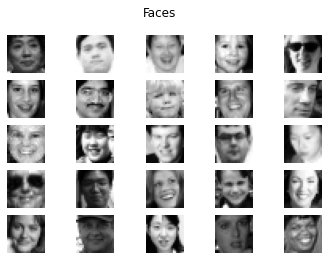

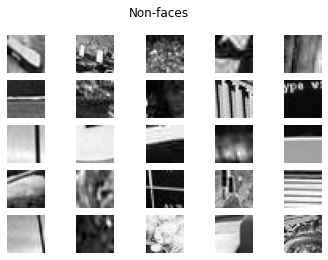

In [38]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,5*i+100], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

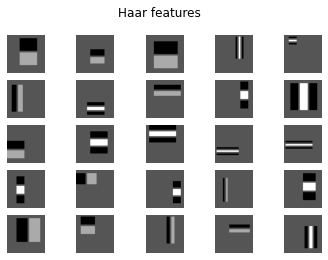

In [4]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [5]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [6]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

#Initialize weight, set start weights to 1/N
d = np.full(nbrTrainImages,(1/nbrTrainImages))

adaboost_his = np.zeros(shape=(nbrWeakClassifiers,3)) 
Alpha = []
for c in range(nbrWeakClassifiers):
    
    minErr = float("inf") #inf
    threshold = 0
    polarity = 0
    feature = 0
    minAlpha = 0
    h = 0
    for feature_idx in  range(nbrHaarFeatures):
        X_column = xTrain[feature_idx,:]
        thresholds = np.unique(X_column)
        for th in thresholds:
            
            p = 1  #iterate through all thresholds, to find best threshold for feature f
            pC = WeakClassifier(th,p,X_column)
           # print(len(X_column))
            e = WeakClassifierError(pC,d,yTrain)
          #  print(e.shape)
            
            if e > 0.5:
                
                p = -1 * p
                e = 1-e
                
            if e < minErr:
                
                minErr = e
               
                threshold = th
                polarity = p
                feature = feature_idx
                h = p*pC
    
    EPS = 1e-10
    minAlpha = 0.5 * np.log((1.0-minErr + EPS)/(minErr + EPS))
   # print(h.shape)
    
    d *= np.exp(-1*minAlpha*yTrain*h).T
    d /= np.sum(d)
  
    
    adaboost_his[c,0] = threshold #update matrix of optimal AdaBoost variables for classifier c
    adaboost_his[c,1] = polarity
    adaboost_his[c,2] = feature
    Alpha.append(minAlpha) #NEW code Saves the minimum alpha for each classification.
    
                
    

In [7]:

# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.
clfs = np.zeros(shape = [nbrWeakClassifiers,yTrain.shape[0]])
train_res = np.zeros(nbrTrainImages)

train_acc = np.zeros(nbrWeakClassifiers)
for c in range(nbrWeakClassifiers):
    clfs[c,:] = WeakClassifier(adaboost_his[c,0],adaboost_his[c,1],xTrain[np.dtype('int32').type(adaboost_his[c,2]),:])
    
    for i in range(nbrTrainImages):
       
        aW = np.zeros(c)
        
        for a in range(c):
             
                aW[a] = Alpha[a] * clfs[a,i]
                
        y_pred = np.sum(aW)
        y_pred = np.sign(y_pred)
      
        train_res[i] = (y_pred != yTrain[i] )
    
    train_acc[c] = 1 - sum(train_res)/nbrTrainImages

In [8]:
np.max(train_acc)

0.997

In [9]:
np.argmax(train_acc)

85

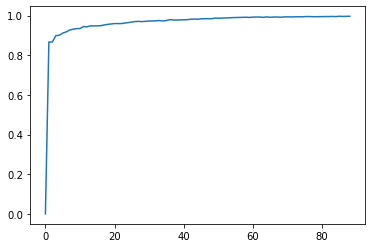

In [10]:
plt.plot(train_acc)

In [11]:
nbrTestImages

(10788,)

In [12]:

# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.
clfs_test = np.zeros(shape = [nbrWeakClassifiers,yTest.shape[0]])
test_res = np.zeros(nbrTestImages)

test_acc = np.zeros(nbrWeakClassifiers)
for c in range(nbrWeakClassifiers):
    clfs_test[c,:] = WeakClassifier(adaboost_his[c,0],adaboost_his[c,1],xTest[np.dtype('int32').type(adaboost_his[c,2]),:])
    
    for i in range(nbrTestImages[0]):
       
        aW = np.zeros(c)
        
        for a in range(c):
             
                aW[a] = Alpha[a] * clfs_test[a,i]
                
        y_pred1 = np.sum(aW)
        y_pred1 = np.sign(y_pred1)
      
        test_res[i] = (y_pred1 != yTest[i] )
    
    test_acc[c] = 1 - sum(test_res)/nbrTestImages

In [13]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

#test_acc

In [14]:
np.max(test_acc)

0.9554134223210975

In [15]:
np.argmax(test_acc)

88

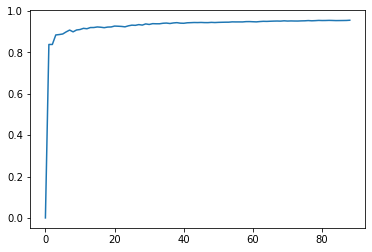

In [16]:
plt.plot(test_acc)


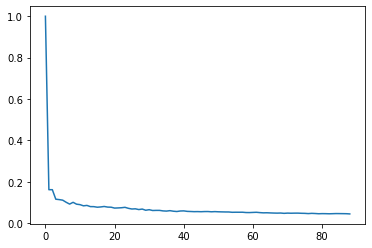

In [17]:
plt.plot(1-test_acc)

In [18]:
miss_class = np.asarray(np.where(test_res == 1))
miss_class = miss_class.flatten()
miss_class[50]

1299

In [19]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.

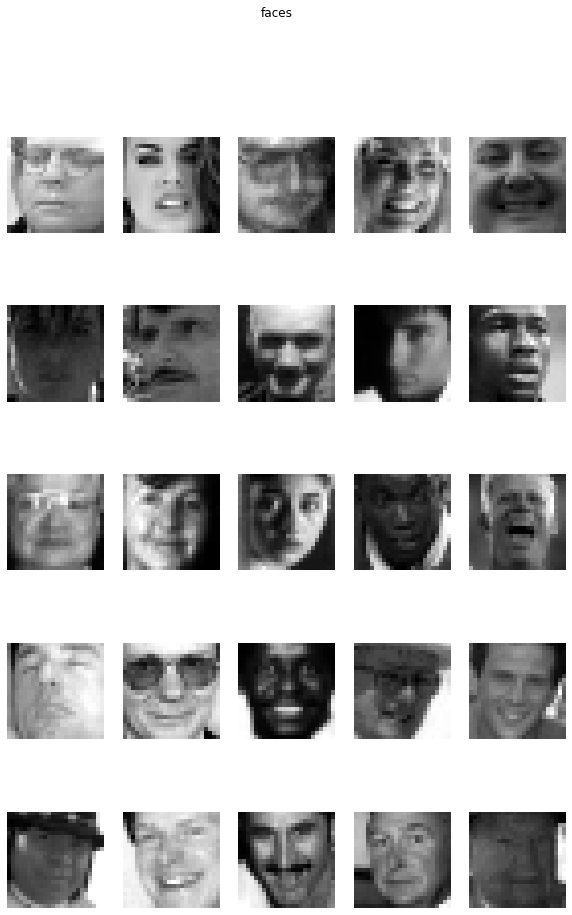

In [52]:
# Load face and non-face data and plot a few examples
plt.figure(figsize=(10,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    c =  miss_class[i]
    plt.imshow(testImages[:,:,c], cmap='gray')
    
    plt.axis('off')
    plt.suptitle('faces')


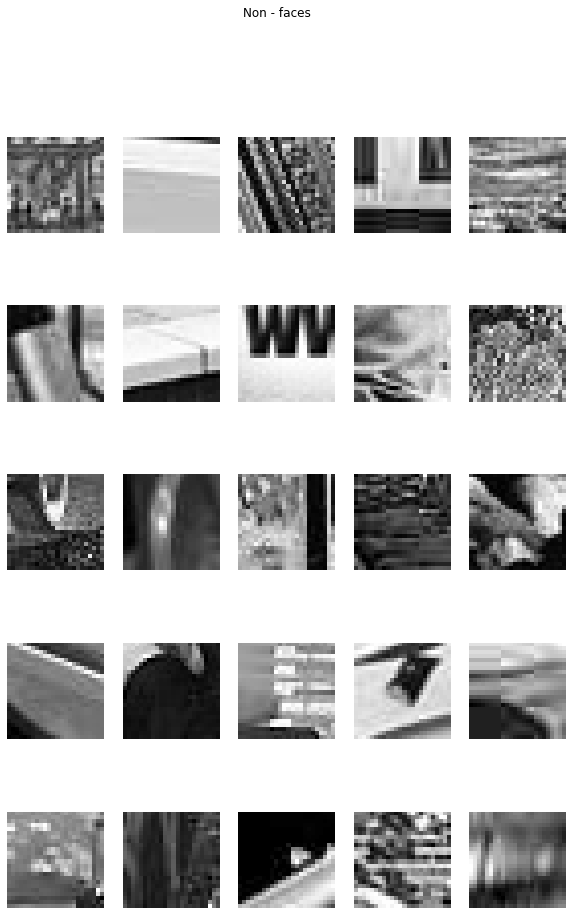

In [55]:
# Load face and non-face data and plot a few examples
plt.figure(figsize=(10,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    c =  miss_class[i+1]
    plt.imshow(testImages[:,:,-9*c+10], cmap='gray')
    
    plt.axis('off')
    plt.suptitle('Non - faces')

Text(0.5, 0.98, 'Haar features')

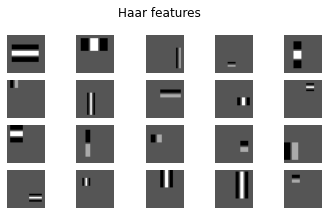

In [22]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.

for i in range(20):
    
    plt.subplot(5,5,i+1)
    plt.imshow(haarFeatureMasks[:,:,np.dtype('int32').type(adaboost_his[i,2])], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')


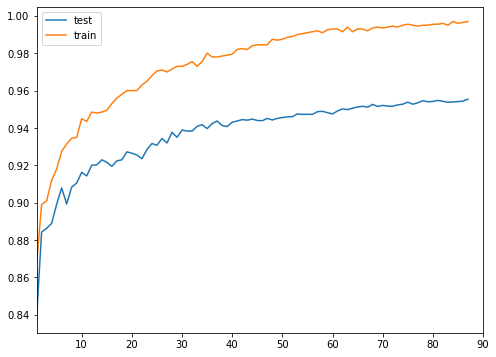

In [35]:
plt.figure(figsize=(8,6))
plt.plot(test_acc[1:],label='test')
plt.plot(train_acc[1:],label='train')
plt.xlim([1,90])
plt.legend()
plt.show()